In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import colorsys
from skimage import color as skcolor

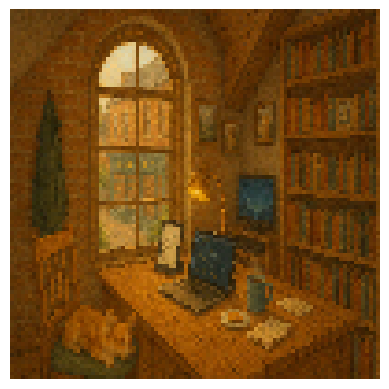

In [22]:
import cv2
import matplotlib.pyplot as plt

image_bgr = cv2.imread('ai_image.png')
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
image_rgb = cv2.resize(image_rgb, (100, 100))
plt.imshow(image_rgb)
plt.axis('off')
plt.show()

## Getting Color Palette

### KNN

In [3]:
pixels = image_rgb.reshape(-1, 3)

In [4]:
from sklearn.cluster import KMeans
from kneed import KneeLocator

In [5]:
inertias = []

k=11
elbow=False
if elbow:
    k_values= range(1,k+1)
    for k in k_values:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
        kmeans.fit(pixels)
        inertias.append(kmeans.inertia_)
    
    k = KneeLocator(k_values, inertias, curve='convex', direction='decreasing').knee

kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
kmeans.fit(pixels)

KMeans(n_clusters=11, random_state=42)

In [6]:
center_pixels = np.round(kmeans.cluster_centers_, 1).astype(int)

In [7]:
hex_codes = []
for rgb in center_pixels:
    hex_code = '#{:02x}{:02x}{:02x}'.format(*rgb)
    hex_codes.append(hex_code)


In [8]:
print(hex_codes)

['#925008', '#572e04', '#ad6610', '#3e2808', '#e0c78b', '#79450a', '#be8835', '#513b12', '#8c6b2c', '#683907', '#30372c']


In [9]:
['#995105', '#603203', '#92601b', '#402808', '#e1c88c', '#72430c', '#ba8233', '#463611', '#7d682d', '#633507', '#2d342a']

['#995105',
 '#603203',
 '#92601b',
 '#402808',
 '#e1c88c',
 '#72430c',
 '#ba8233',
 '#463611',
 '#7d682d',
 '#633507',
 '#2d342a']

In [10]:
import matplotlib.patches as mpatch

In [11]:
def plot_color_swatch(hex_codes):
    fig, ax = plt.subplots(figsize=(len(hex_codes), 2))
    for i, hex_code in enumerate(hex_codes):
        rect = mpatch.Rectangle((i, 0), 1, 1, color=hex_code)
        ax.add_patch(rect)

    ax.set_xlim(0, len(hex_codes))
    ax.set_ylim(0, 1)
    ax.axis('off')
    plt.savefig('swatch.png', dpi=300, bbox_inches='tight')

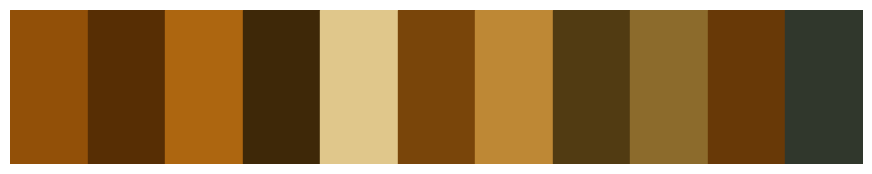

In [12]:
plot_color_swatch(hex_codes)

### GMM

In [13]:
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt

bics = []
k = 20
bics_bool = False
if bics_bool:
    k_range = range(1,k+1)
    for k in k_range: 
        gmm = GaussianMixture(n_components=k, random_state=42)
        gmm.fit(pixels)
        bics.append(gmm.bic(pixels))
        k = k_range[bics.index(min(bics))]
gmm = GaussianMixture(n_components=k, random_state=42)
gmm.fit(pixels)


GaussianMixture(n_components=20, random_state=42)

In [14]:
gmm_means = np.round(gmm.means_).astype(int)

In [15]:
hex_codes = []
for rgb in gmm_means:
    hex_code = '#{:02x}{:02x}{:02x}'.format(*rgb)
    hex_codes.append(hex_code)


In [16]:
print(hex_codes)

['#9e5406', '#5f3306', '#98641d', '#412708', '#e0c88c', '#764108', '#b8893e', '#40330f', '#77652a', '#513810', '#2d342b', '#643d0e', '#bb7b26', '#8a4703', '#502a03', '#837037', '#7f4d10', '#6c3603', '#d28814', '#b16209']


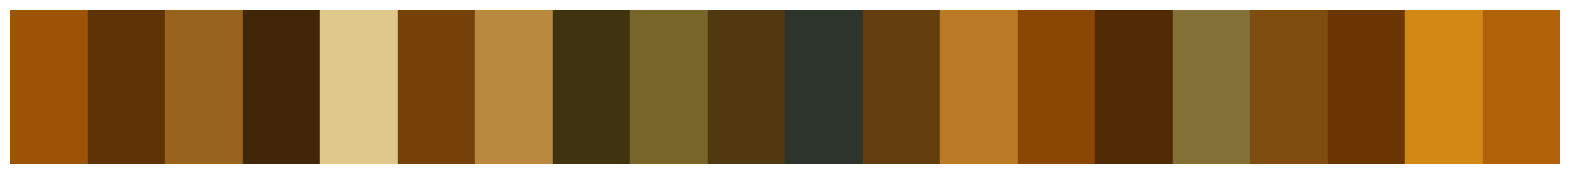

In [17]:
plot_color_swatch(hex_codes)

In [18]:
def hex_to_rgb_normalized(hex_color):
    hex_color = hex_color.lstrip('#')
    r = int(hex_color[0:2], 16) / 255
    g = int(hex_color[2:4], 16) / 255
    b = int(hex_color[4:6], 16) / 255
    return (r, g, b)

def rgb_normalized_to_hex(rgb_normalized):
    r = int(round(rgb_normalized[0] * 255))
    g = int(round(rgb_normalized[1] * 255))
    b = int(round(rgb_normalized[2] * 255))
    return '#{:02x}{:02x}{:02x}'.format(r, g, b)



def hex_to_lab(hex_color):
    rgb = np.array(hex_to_rgb_normalized(hex_color)).reshape(1, 1, 3)
    lab = skcolor.rgb2lab(rgb)
    return lab[0, 0]


def delta_e(lab1, lab2):
    return np.linalg.norm(lab1 - lab2)


def interpolate_hsl_gradient(color1_hex, color2_hex, steps=10):
    
    rgb1 = hex_to_rgb_normalized(color1_hex)
    rgb2 = hex_to_rgb_normalized(color2_hex)
    
    h1, l1, s1 = colorsys.rgb_to_hls(*rgb1)
    h2, l2, s2 = colorsys.rgb_to_hls(*rgb2)
    
    if abs(h2 - h1) > 0.5:
        if h1 > h2:
            h2 += 1
        else:
            h1 += 1

    h_step = (h2 - h1) / (steps - 1)
    l_step = (l2 - l1) / (steps - 1)
    s_step = (s2 - s1) / (steps - 1)
    
    gradient = []
    
    for i in range(steps):
        h = (h1 + i * h_step) % 1.0
        l = l1 + i * l_step
        s = s1 + i * s_step
        
        rgb = colorsys.hls_to_rgb(h, l, s)
        hex_color = rgb_normalized_to_hex(rgb)
        gradient.append(hex_color)
    
    return gradient


def generate_full_hsl_gradient(palette, steps_per_transition=50, duplicate_threshold=5):
    """Expand palette by interpolating smooth HSL gradients between adjacent colors."""
    
    full_gradient = []
    n = len(palette)
    
    for i in range(n):
        color_start = palette[i]
        color_end = palette[(i + 1) % n]  # wrap around for full circle
        gradient = interpolate_hsl_gradient(color_start, color_end, steps=steps_per_transition)
        full_gradient.extend(gradient[:-1])  # skip last color to avoid duplication

    full_gradient = deduplicate_colors(full_gradient, duplicate_threshold)
    return full_gradient

def deduplicate_colors(colors, threshold=5):
    labs = [hex_to_lab(c) for c in colors]
    deduped_colors = colors.copy()
    
    i = 0
    while i < len(labs):
        j = i + 1
        while j < len(labs):
            if delta_e(labs[i], labs[j]) < threshold:
                # Remove the second color if too similar
                deduped_colors.pop(j)
                labs.pop(j)
            else:
                j += 1
        i += 1
    
    return deduped_colors

def sort_palette_by_closeness(colors):
    if not colors:
        return []
    
    labs = [hex_to_lab(c) for c in colors]
    used = [False] * len(colors)
    
    sorted_colors = []
    current_idx = 0
    sorted_colors.append(colors[current_idx])
    used[current_idx] = True
    
    for _ in range(len(colors) - 1):
        min_dist = float('inf')
        next_idx = None
        
        for j in range(len(colors)):
            if not used[j]:
                dist = delta_e(labs[current_idx], labs[j])
                if dist < min_dist:
                    min_dist = dist
                    next_idx = j
        
        sorted_colors.append(colors[next_idx])
        used[next_idx] = True
        current_idx = next_idx
    
    return sorted_colors

def plot_color_wheel_gradient(colors):
    colors = sort_palette_by_closeness(colors)
    total_steps = len(colors)
    angles = np.linspace(0, 2*np.pi, total_steps, endpoint=False)
    
    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))
    
    ax.set_theta_offset(np.pi / 2)   
    ax.set_theta_direction(-1)      

    # Plot each tiny bar
    for angle, color in zip(angles, colors):
        ax.bar(angle, 1, width=2*np.pi/total_steps, color=color, edgecolor=color, linewidth=0)

    ax.set_axis_off()
    plt.tight_layout()
    plt.show()




In [19]:
hex_codes

['#9e5406',
 '#5f3306',
 '#98641d',
 '#412708',
 '#e0c88c',
 '#764108',
 '#b8893e',
 '#40330f',
 '#77652a',
 '#513810',
 '#2d342b',
 '#643d0e',
 '#bb7b26',
 '#8a4703',
 '#502a03',
 '#837037',
 '#7f4d10',
 '#6c3603',
 '#d28814',
 '#b16209']

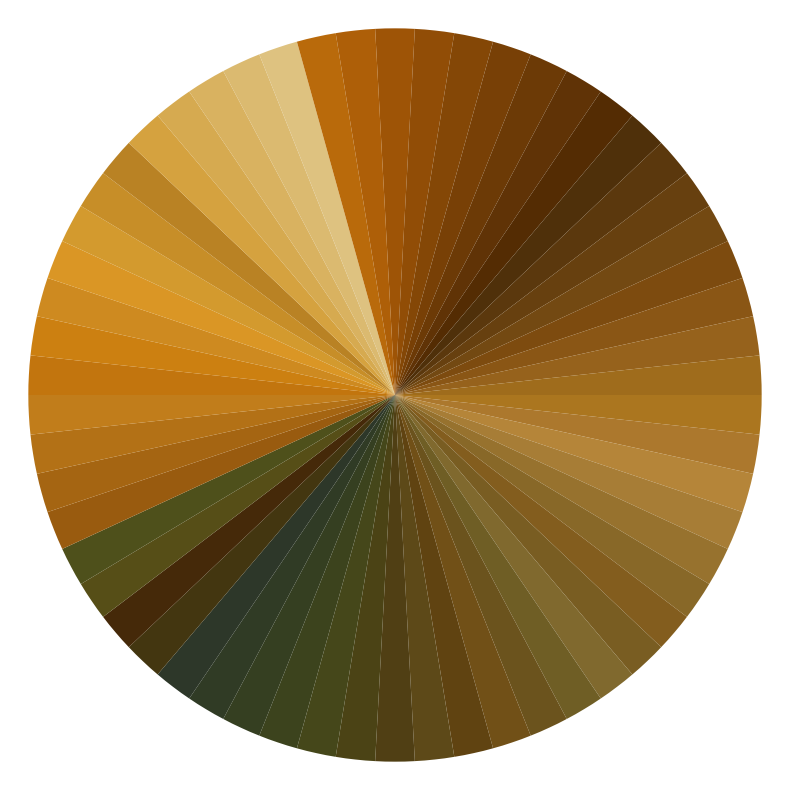

In [20]:
full_gradient = generate_full_hsl_gradient(hex_codes, steps_per_transition=80)

# Step 2: Plot the gradient as a color wheel
plot_color_wheel_gradient(full_gradient)
